In [1]:
from data import load_data
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import os 

# Parameters

In [2]:
dataset='GunPoint'

# Load Data

In [3]:
#TODO include OneHot Encoding Options
train_x,test_x, train_y, test_y = load_data.load_basic_dataset(dataset,scaling=None,mode='feat',cwd='/media/jacqueline/Data/UCRArchive_2018/')

In [4]:
print(test_y.shape)

(150,)


In [5]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
pickle.dump(enc1,open(f'./ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))
    

# Model Training

In [6]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
model = ResNetBaseline(in_channels=1, num_pred_classes=n_pred_classes)
fit(model,train_loader,test_loader)
if dataset in os.listdir('./ClassificationModels/models/'):
    print('Folder exists')
else: 
    os.mkdir(f'./ClassificationModels/models/{dataset}')
torch.save(model.state_dict(), f'./ClassificationModels/models/{dataset}/ResNet')

test_preds, ground_truth = get_all_preds(model, test_loader)
ground_truth=np.argmax(ground_truth,axis=1)

sns.set(rc={'figure.figsize':(5,4)})
heatmap=confusion_matrix(ground_truth, test_preds)
sns.heatmap(heatmap, annot=True)
plt.savefig(f'./ClassificationModels/models/{dataset}/ResNet_confusion_matrix.png')
plt.close()
acc= accuracy_score(ground_truth, test_preds)
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'./ClassificationModels/models/{dataset}/classification_report.csv', index = False)

Epoch: 1, Train loss: 0.576, Val loss: 0.689
Epoch: 2, Train loss: 0.738, Val loss: 0.706
Epoch: 3, Train loss: 0.791, Val loss: 0.706
Epoch: 4, Train loss: 0.699, Val loss: 0.699
Epoch: 5, Train loss: 0.66, Val loss: 0.74
Epoch: 6, Train loss: 0.816, Val loss: 0.703
Epoch: 7, Train loss: 0.693, Val loss: 0.693
Epoch: 8, Train loss: 0.693, Val loss: 0.692
Epoch: 9, Train loss: 0.691, Val loss: 0.692
Epoch: 10, Train loss: 0.691, Val loss: 0.691
Epoch: 11, Train loss: 0.683, Val loss: 0.69
Epoch: 12, Train loss: 0.711, Val loss: 0.692
Epoch: 13, Train loss: 0.699, Val loss: 0.688
Epoch: 14, Train loss: 0.672, Val loss: 0.685
Epoch: 15, Train loss: 0.685, Val loss: 0.681
Epoch: 16, Train loss: 0.691, Val loss: 0.674
Epoch: 17, Train loss: 0.675, Val loss: 0.67
Epoch: 18, Train loss: 0.698, Val loss: 0.704
Epoch: 19, Train loss: 0.701, Val loss: 0.685
Epoch: 20, Train loss: 0.683, Val loss: 0.681
Epoch: 21, Train loss: 0.68, Val loss: 0.672
Epoch: 22, Train loss: 0.674, Val loss: 0.662
Ep

/home/jacqueline/.local/share/virtualenvs/InterpretabiltyTimeSeries-y2AnfPaS/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jacqueline/.local/share/virtualenvs/InterpretabiltyTimeSeries-y2AnfPaS/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jacqueline/.local/share/virtualenvs/InterpretabiltyTimeSeries-y2AnfPaS/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no

# Explanation Algo

In [7]:
explained_instance = train_x[0]
nb_interpretable_feature = 10
explanation_size = 5
nb_neighbors = 1000
learning_process_name = 'Lime'
transform_name = 'straight_line'
model_to_explain=model

In [8]:
from InterpretabilityModels.leftist.LEFTIST import LEFTIST
from InterpretabilityModels.leftist.timeseries.segmentator.uniform_segmentator import UniformSegmentator

In [10]:
segmentator = UniformSegmentator(nb_interpretable_feature)
leftist = LEFTIST(test_x,'straight_line',segmentator,model_to_explain,learning_process_name,mode='feat', backend='torch')

In [11]:
explanations = leftist.explain(np.array(explained_instance),1000,explanation_size=explanation_size)

Instance (1, 150)
nb_features 10
nb_neighbors 1000
NM [[0 0 1 ... 1 0 1]
 [1 1 1 ... 1 0 1]
 [0 1 1 ... 1 0 1]
 ...
 [1 1 0 ... 0 0 1]
 [0 0 0 ... 1 1 0]
 [0 1 0 ... 1 1 0]]
masks : 
 [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 0 1]
 [0 1 1 ... 1 0 1]
 ...
 [1 1 0 ... 0 0 1]
 [0 0 0 ... 1 1 0]
 [0 1 0 ... 1 1 0]] 
 kernel_weights : 
 None 
 values : 
 None 
 proba_labels : 
 None 
 
NV [[[-0.6478854 ]
  [-0.64199155]
  [-0.63818632]
  ...
  [-0.64042873]
  [-0.63866571]
  [-0.63865722]]

 [[-0.6478854 ]
  [-0.64199155]
  [-0.63818632]
  ...
  [-0.64042873]
  [-0.63866571]
  [-0.63865722]]

 [[-0.6478854 ]
  [-0.64875881]
  [-0.64963223]
  ...
  [-0.64042873]
  [-0.63866571]
  [-0.63865722]]

 ...

 [[-0.6478854 ]
  [-0.64199155]
  [-0.63818632]
  ...
  [-0.64042873]
  [-0.63866571]
  [-0.63865722]]

 [[-0.6478854 ]
  [-0.64875881]
  [-0.64963223]
  ...
  [-0.63824779]
  [-0.6384525 ]
  [-0.63865722]]

 [[-0.6478854 ]
  [-0.64875881]
  [-0.64963223]
  ...
  [-0.63824779]
  [-0.6384525 ]
  [-0.6386

/media/jacqueline/Data/InterpretabiltyTimeSeries/InterpretabilityModels/utils.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = torch.nn.functional.softmax(out).detach().numpy()


In [12]:
for i in range(len(explanations)):
    print('class{} : '.format(i),explanations[i][0])

class0 :  [-4.72941720e-07 -1.16834867e-10 -1.77356311e-11  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.86029478e-11  1.94125752e-10]
class1 :  [-1.94125752e-10 -9.86029478e-11  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.77356311e-11
  1.16834867e-10  4.72941720e-07]


[-4.72941720e-07 -1.16834867e-10 -1.77356311e-11  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.86029478e-11  1.94125752e-10]
-4.72941720059013e-07
0.0
-1.168348672894354e-10
15.0
-1.77356310616398e-11
30.0
0.0
45.0
0.0
60.0
0.0
75.0
0.0
90.0
0.0
105.0
9.8602947760425e-11
120.0
1.9412575173537976e-10
135.0


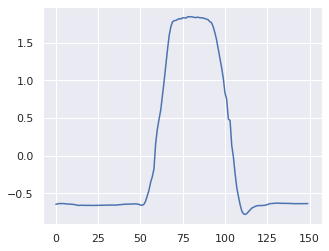

In [14]:
leftist.plot_on_sample(explained_instance.flatten(),explanations)